# Defining your own mechanisms such as channels and synapses

`neurax` provides an implementation of the standard Hodgkin-Huxley equations and of glutamatergic synapses. In this tutorial, we will explain how you can define your own mechanisms.

In [1]:
%load_ext autoreload
%autoreload 2

# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import HHChannel
from neurax.synapses import GlutamateSynapse

### Setup

In [105]:
# Number of segments per branch.
nseg_per_branch = 1

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define a cell

In [158]:
comp = nx.Compartment()
branch = nx.Branch([comp for _ in range(nseg_per_branch)])
#cell = nx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1]))

# point neuron:
cell = nx.Cell([branch for _ in range(1)], parents=jnp.asarray([-1]))

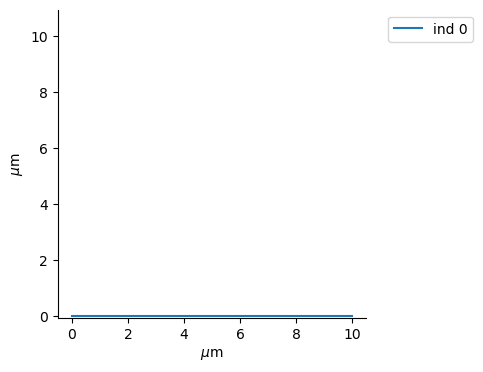

In [159]:
_ = nx.utils.plot_morph(cell, figsize=(4, 4), cols="k", highlight_branch_inds=[0, 1, 2,6])

In [160]:
cell.show()

,comp_index,branch_index,cell_index,length,radius,axial_resistivity,voltages
0,0,0,0,10.0,1.0,5000.0,-70.0


In [114]:
#cell.set_params("radius", 10)
#cell.set_params("axial_resistivity", 1)

### Define stimuli and recordings

In [179]:
stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(1.0, 20.0, 5, time_vec))]
recs = [nx.Recording(0, 0, 0.0)]

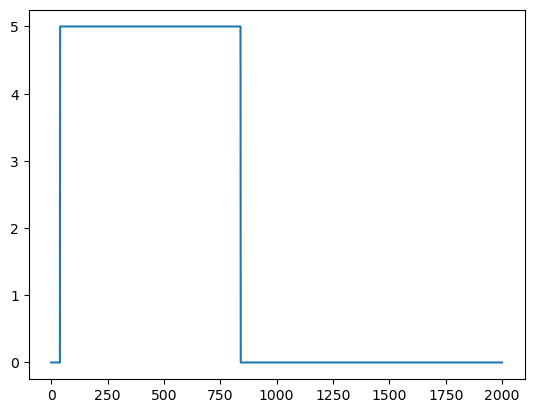

In [180]:
plt.plot(stims[0].current)

### Your own channel
Below is how you can define your own channel. We will go into detail about individual parts of the code in the next couple of cells.

In [270]:
from typing import Dict, Optional

import jax.numpy as jnp
from neurax.channels import Channel
from neurax.solver_gate import solve_gate_exponential, solve_inf_gate_exponential

In [220]:
?Channel

Init signature: Channel()
Docstring:      <no docstring>
File:           ~/Documents/projects/neurax/neurax/neurax/channels/channel.py
Type:           type
Subclasses:     HHChannel, NaChannelPospi, NaChannelPospi, KChannelPospi, HHChannel, Potassium, NaKChannelsPospi

In [163]:

class HHChannel(Channel):
    """Hodgkin-Huxley channel."""

    channel_params = {"gNa": 0.12, "gK": 0.036, "gLeak": 0.0003}
    channel_states = {"m": 0.2, "h": 0.2, "n": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated HH channel state and current."""
        ms, hs, ns = u["m"], u["h"], u["n"]
        new_m = solve_gate_exponential(ms, dt, *_m_gate(voltages))
        new_h = solve_gate_exponential(hs, dt, *_h_gate(voltages))
        new_n = solve_gate_exponential(ns, dt, *_n_gate(voltages))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        na_conds = params["gNa"] * (new_m**3) * new_h * 1000  # mS/cm^2
        kd_conds = params["gK"] * new_n**4 * 1000  # mS/cm^2
        leak_conds = params["gLeak"] * 1000  # mS/cm^2

        voltage_term = na_conds + kd_conds + leak_conds

        e_na = 50.0
        e_kd = -77.0
        e_leak = -54.3
        constant_term = na_conds * e_na + kd_conds * e_kd + leak_conds * e_leak

        return {"m": new_m, "h": new_h, "n": new_n}, (voltage_term, constant_term)


def _m_gate(v):
    alpha = 0.1 * _vtrap(-(v + 40), 10)
    beta = 4.0 * jnp.exp(-(v + 65) / 18)
    return alpha, beta


def _h_gate(v):
    alpha = 0.07 * jnp.exp(-(v + 65) / 20)
    beta = 1.0 / (jnp.exp(-(v + 35) / 10) + 1)
    return alpha, beta


def _n_gate(v):
    alpha = 0.01 * _vtrap(-(v + 55), 10)
    beta = 0.125 * jnp.exp(-(v + 65) / 80)
    return alpha, beta


def _vtrap(x, y):
    return x / (jnp.exp(x / y) - 1.0)




def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)

class Potassium(Channel):
    """Potassium channel."""

    channel_params = {"gK_new": 0.06}
    channel_states = {"n_new": 0.1}

    @staticmethod
    def step(u, dt, voltages, params):
        """Return updated HH channel state and current."""
        ns = u["n_new"]
        alpha = 0.01 * exp_update_alpha(-(voltages + 55), 10)
        beta = 0.125 * jnp.exp(-(voltages + 65) / 80)
        new_n = solve_gate_exponential(ns, dt, alpha, beta)

        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_new"] * new_n**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        current = kd_conds * (e_kd - voltages)

        return {"n_new": new_n}, (jnp.zeros_like(current), current)

In [239]:
# Pospischil channels

class NaChannelPospi(Channel):
    """Sodium channel"""

    channel_params = {"gNa": 0.05, "eNa": 50.0, "vt":-60.}
    channel_states = {"m": 0.2, "h": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ms, hs = u["m"], u["h"]
        new_m = solve_gate_exponential(ms, dt, *_m_gate(voltages, params["vt"]))
        new_h = solve_gate_exponential(hs, dt, *_h_gate(voltages, params["vt"]))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        na_conds = params["gNa"] * (new_m**3) * new_h * 1000  # mS/cm^2
       
        current = na_conds * (params["eNa"] - voltages)


        return {"m": new_m, "h": new_h}, (jnp.zeros_like(current), current)

def _m_gate(v,vt):
    v_alpha = v - vt - 13.
    alpha = 0.32 * efun(-0.25 * v_alpha)/0.25
    
    v_beta = v - vt - 40. 
    beta = 0.28 * efun(0.2 * v_beta) / 0.2
    return alpha, beta

def _h_gate(v,vt):
    v_alpha = v - vt - 17.
    alpha = 0.128 * jnp.exp(-v_alpha / 18.)
    
    v_beta = v - vt - 40.
    beta = 4.0 / (jnp.exp(-v_beta / 5.) + 1.)
    return alpha, beta

def efun(x):
    # x/[exp(x)-1]
    return x / (jnp.exp(x) - 1.0)



class KChannelPospi(Channel):
    """Potassium channel"""

    channel_params = {"gK": 0.005, "eK": -90., "vt":-60.}
    channel_states = {"n": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ns = u["n"]
        new_n = solve_gate_exponential(ns, dt, *_n_gate(voltages, params["vt"]))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        k_conds = params["gK"] * (new_n**4) * 1000  # mS/cm^2
       
        current = k_conds * (params["eK"] - voltages)


        return {"n": new_n}, (jnp.zeros_like(current), current)

def _n_gate(v,vt):
    v_alpha = v - vt - 15.
    alpha = 0.032 * efun(-0.2 * v_alpha)/0.2
    
    v_beta = v - vt - 10.
    beta = 0.5 * jnp.exp(-v_beta/40.)
    return alpha, beta


class KmChannelPospi(Channel):
    TODO: check again.
    """Slow M Potassium channel"""

    channel_params = {"gM": 0.004*1e-3, "taumax": 4.0, "eM":-90.}
    # eM is the reversal potential of K, should be set to eK if another K channel is present
    channel_states = {"p": 0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ps = u["p"]
        new_p = solve_inf_gate_exponential(ns, dt, *_p_gate(voltages, params["taumax"]))

        # Multiply with 1000 to convert Siemens to milli Siemens.
        m_conds = params["gM"] * new_p * 1000  # mS/cm^2
       
        current = m_conds * (params["eM"] - voltages)


        return {"p": new_n}, (jnp.zeros_like(current), current)

def _p_gate(v,taumax):
    v_p = v + 35.
    p_inf = 1. / ( 1. + jnp.exp(-0.1 * v_p))
    
    tau_p = taumax / (3.3 * jnp.exp(0.2 * v_p) + jnp.exp(-0.05 * v_p) )
    
    return p_inf, tau_p


In [267]:
?solve_gate_exponential

Signature:
solve_gate_exponential(
    x: jax.Array,
    dt: float,
    alpha: jax.Array,
    beta: jax.Array,
)
Docstring: <no docstring>
File:      ~/Documents/projects/neurax/neurax/neurax/solver_gate.py
Type:      function

In [266]:
1e-3 * 1000

1.0

In [252]:
# Pospischil channels

class NaKChannelsPospi(Channel):
    """Sodium channel"""

    channel_params = {"gNa": 0.05, 
                      "eNa": 50.0,
                      "gK": 0.005,#0.005, 
                      "eK": -90.0, 
                      "vt":-60}
    
    channel_states = {"m": 0.2, "h": 0.2, "n":0.2}

    @staticmethod
    def step(u: Dict[str, jnp.ndarray], dt, voltages, params: Dict[str, jnp.ndarray]):
        """Return updated channel states and current."""
        ms, hs, ns = u["m"], u["h"], u["n"]
        new_m = solve_gate_exponential(ms, dt, *_m_gate(voltages, params["vt"]))
        new_h = solve_gate_exponential(hs, dt, *_h_gate(voltages, params["vt"]))
        new_n = solve_gate_exponential(ns, dt, *_n_gate(voltages, params["vt"]))


        # Multiply with 1000 to convert Siemens to milli Siemens.
        na_conds = params["gNa"] * (new_m**3) * new_h * 1000  # mS/cm^2
        k_conds = params["gK"] * (new_n**4) * 1000  # mS/cm^2

        current = na_conds * (params["eNa"] - voltages) +  k_conds * (params["eK"] - voltages)


        return {"m": new_m, "h": new_h, "n":new_n}, (jnp.zeros_like(current), current)

def _m_gate(v,vt):
    v_alpha = v - vt - 13.
    alpha = 0.32 * efun(-0.25 * v_alpha)/0.25
    
    v_beta = v - vt - 40. 
    beta = 0.28 * efun(0.2 * v_beta) / 0.2
    return alpha, beta

def _h_gate(v,vt):
    v_alpha = v - vt -17
    alpha = 0.128 * jnp.exp(-v_alpha / 18)
    
    v_beta = v - vt - 40
    beta = 4.0 / (jnp.exp(-v_beta / 5) + 1)
    return alpha, beta

def efun(x):
    # x/[exp(x)-1]
    return x / (jnp.exp(x) - 1.0)


def _n_gate(v,vt):
    v_alpha = v - vt - 15.
    alpha = 0.032 * efun(-0.2 * v_alpha)/0.2
    
    v_beta = v - vt - 10 
    beta = 0.5 * jnp.exp(-v_beta/40)
    return alpha, beta


In [261]:
comp = nx.Compartment()
branch = nx.Branch([comp for _ in range(nseg_per_branch)])
cell = nx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1]))


In [165]:
cell.insert(HHChannel)
#cell.insert(Potassium)

In [262]:
cell.insert(NaChannelPospi)
cell.insert(KChannelPospi)

In [254]:
cell.insert(NaKChannelsPospi)

In [263]:
stims = [nx.Stimulus(0, 0, 0.0, nx.step_current(1.0, 20.0, 0.03, time_vec))]
recs = [nx.Recording(0, 0, 0.0)]

s = nx.integrate(cell, stims, recs)

TypeError: mul got incompatible shapes for broadcasting: (5,), (10,).

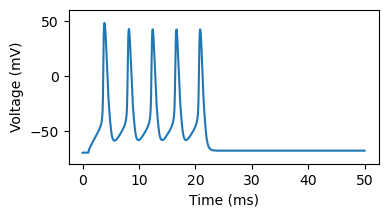

In [260]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-80, 60])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")